### Import & utils

In [ ]:
! pip install -U statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 4.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 6.6 MB/s 
     |████████████████████████████████| 9.8 MB 40.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA, ARIMAResultsWrapper
import pmdarima as pm

In [ ]:
def plot_arima_results(arima_res: ARIMAResultsWrapper, df: pd.core.frame.DataFrame, transform=lambda x:x, plot_train=True):
  d = max(arima_res.specification.get('k_diff'),
          arima_res.specification.get('k_seasonal_diff')*arima_res.specification.get('seasonal_periods'))
  n_train = len(arima_res.fittedvalues)
  forecast_steps = len(df) - n_train
  forecast = arima_res.get_forecast(forecast_steps)
  print(f'RMSE = {np.sqrt(np.mean((transform(forecast.predicted_mean.to_numpy()) - df.iloc[-forecast_steps:,0].to_numpy())**2)):.4f}')

  fig, ax = plt.subplots(figsize=(15,5))
  ax.plot(df.iloc[0 if plot_train else n_train:], label='data')
  if plot_train: ax.plot(df.index[d:n_train], arima_res.fittedvalues.iloc[d:].apply(transform), color='green', label='fitted')
  ax.plot(df.index[-forecast_steps:], forecast.predicted_mean.apply(transform), label='forecast')
  ax.fill_between(df.index[-forecast_steps:], *forecast.conf_int().apply(transform).to_numpy().transpose(), color='red', alpha=0.3)
  ax.legend()


def plot_pmdarima_results(arima: pm.arima.arima.ARIMA, df: pd.core.frame.DataFrame, transform=lambda x:x, plot_train=True):
  d = max(arima.order[1],
          arima.seasonal_order[1]*arima.seasonal_order[3])
  n_train = len(arima.fittedvalues())
  forecast_steps = len(df) - n_train
  forecast, confint = arima.predict(forecast_steps, return_conf_int=True)
  print(f'RMSE = {np.sqrt(np.mean((transform(forecast.to_numpy()) - df.iloc[-forecast_steps:,0].to_numpy())**2)):.4f}')

  fig, ax = plt.subplots(figsize=(15,5))
  ax.plot(df.iloc[0 if plot_train else n_train:], label='data')
  if plot_train: ax.plot(df.index[d:n_train], arima.fittedvalues().iloc[d:].apply(transform), color='green', label='fitted')
  ax.plot(df.index[-forecast_steps:], forecast.apply(transform), label='forecast')
  ax.fill_between(df.index[-forecast_steps:], *transform(confint).transpose(), color='red', alpha=0.3)
  ax.legend()

### Load data

In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

--2022-09-19 06:29:16--  https://lazyprogrammer.me/course_files/airline_passengers.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2036 (2.0K) [text/csv]
Saving to: ‘airline_passengers.csv’

airline_passengers. 100%[===================>]   1.99K  --.-KB/s    in 0s      

2022-09-19 06:29:16 (31.9 MB/s) - ‘airline_passengers.csv’ saved [2036/2036]



In [ ]:
!head airline_passengers.csv

"Month","Passengers"
"1949-01",112
"1949-02",118
"1949-03",132
"1949-04",129
"1949-05",121
"1949-06",135
"1949-07",148
"1949-08",148
"1949-09",136


In [ ]:
!tail airline_passengers.csv

"1960-03",419
"1960-04",461
"1960-05",472
"1960-06",535
"1960-07",622
"1960-08",606
"1960-09",508
"1960-10",461
"1960-11",390
"1960-12",432

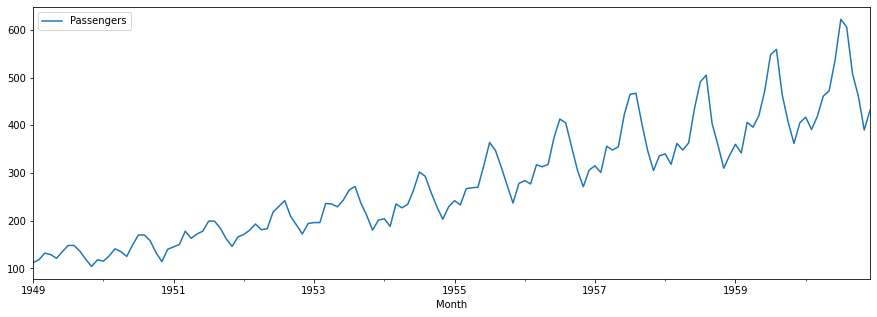

In [ ]:
df = pd.read_csv("airline_passengers.csv", index_col="Month", parse_dates=True)
df.index.freq = df.index.inferred_freq
df.plot(figsize=(15,5));

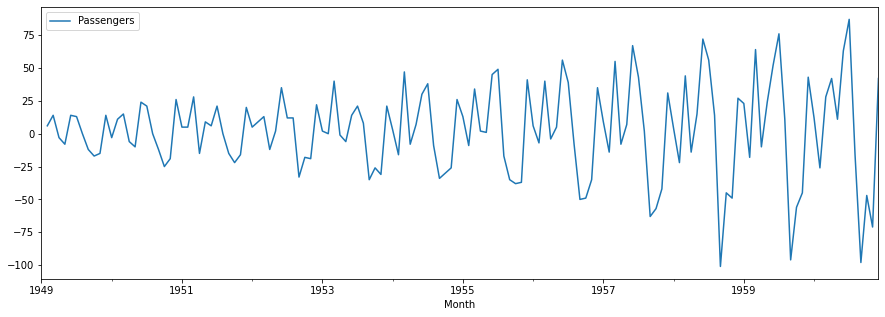

In [ ]:
# plot first differences
df.diff().plot(figsize=(15,5));

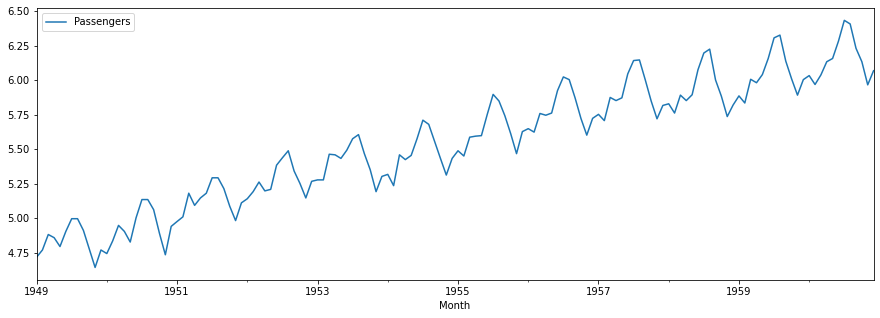

In [ ]:
# plot log
df.apply(np.log).plot(figsize=(15,5));

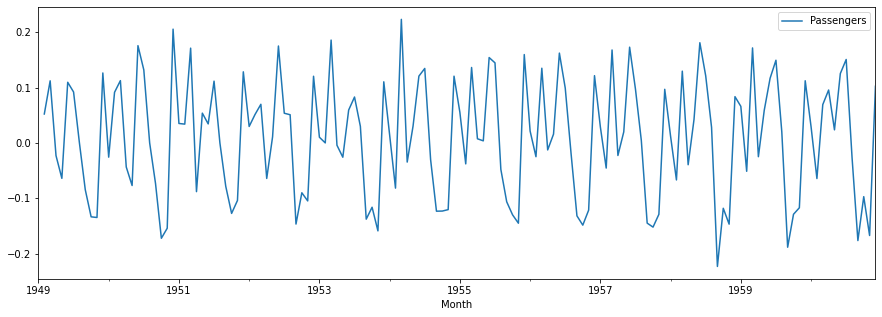

In [ ]:
# plot log diff
# After taking log and diff, the data looks stationary
df.apply(np.log).diff().plot(figsize=(15,5));

### ARIMA

RMSE = 129.2228


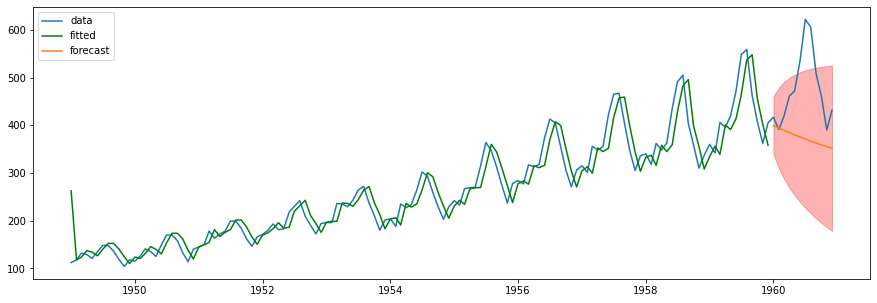

In [ ]:
arima_param = (1,0,0)  # AR(1)
Ntest = 12  # 1 year
target_col = "Passengers"

ar = ARIMA(df.iloc[:-Ntest][target_col], order=arima_param)
ar_res = ar.fit()
plot_arima_results(ar_res, df)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


RMSE = 62.0862


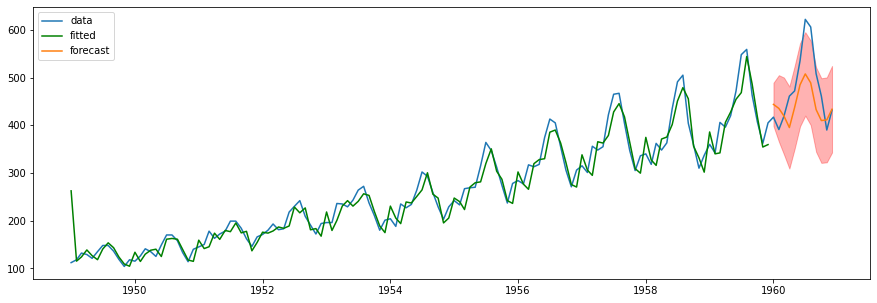

In [ ]:
# Increasing p gives much better results
arima_param = (10,0,0)  # AR(10)
Ntest = 12  # 1 year
target_col = "Passengers"

ar = ARIMA(df.iloc[:-Ntest][target_col], order=arima_param)
ar_res = ar.fit()
plot_arima_results(ar_res, df)

RMSE = 56.0960


1

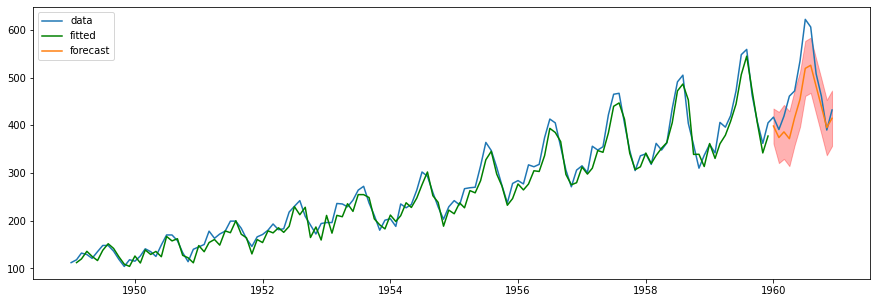

In [ ]:
# We have seen that the first differences look more stationary,
# hence expect that I(1) improves the fit.
arima_param = (10,1,0)
Ntest = 12  # 1 year
target_col = "Passengers"

ar = ARIMA(df.iloc[:-Ntest][target_col], order=arima_param)
ar_res = ar.fit()
plot_arima_results(ar_res, df)
ar_res.specification.get('k_diff')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


RMSE = 17.4924


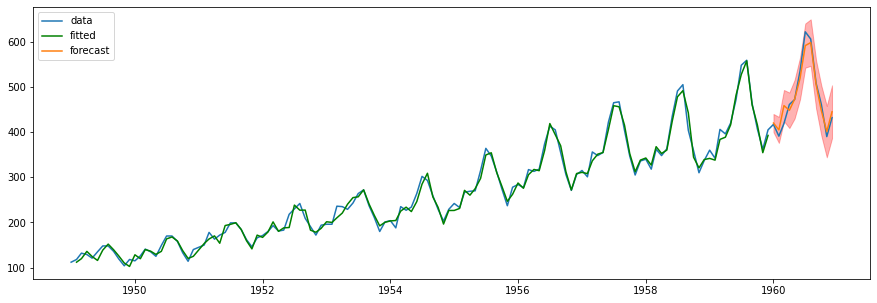

In [ ]:
# At p=12 the fit improves significantly. This is due to seasonality with periods=12
arima_param = (12,1,0)
Ntest = 12  # 1 year
target_col = "Passengers"

ar = ARIMA(df.iloc[:-Ntest][target_col], order=arima_param)
ar_res = ar.fit()
plot_arima_results(ar_res, df)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


RMSE = 16.1379


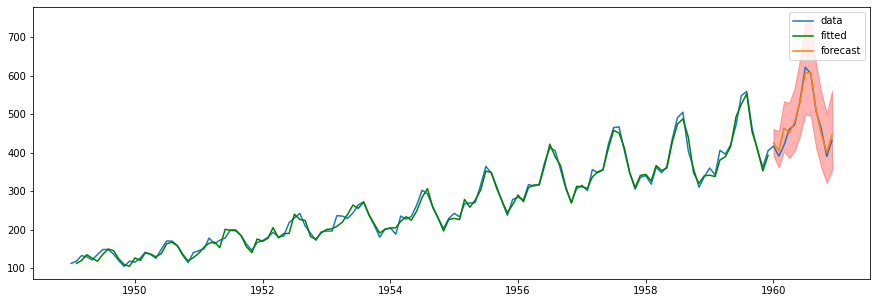

In [ ]:
# Taking the log improves the model, but only marginally
# Fit ARIMA(12,1,0) on log values
arima_param = (12,1,0)
Ntest = 12  # 1 year
target_col = "Passengers"

ar = ARIMA(df.apply(np.log).iloc[:-Ntest][target_col], order=arima_param)  # apply log to df before fitting
ar_res = ar.fit()
plot_arima_results(ar_res, df, transform=np.exp)  # apply exp to fit results

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


RMSE = 21.7016


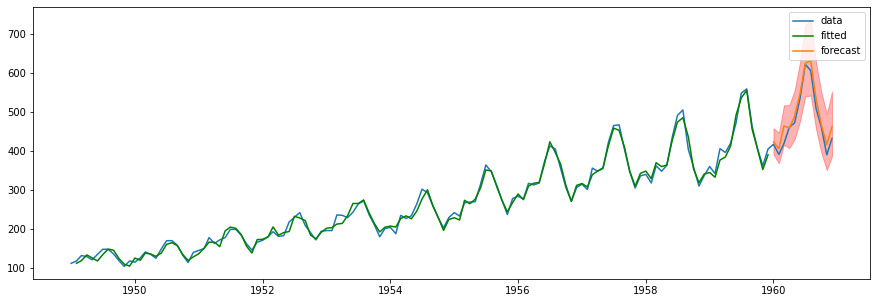

In [ ]:
# Adding MA(1) does not improve the model
arima_param = (12,1,1)
Ntest = 12  # 1 year
target_col = "Passengers"

ar = ARIMA(df.apply(np.log).iloc[:-Ntest][target_col], order=arima_param)  # apply log to df before fitting
ar_res = ar.fit()
plot_arima_results(ar_res, df, transform=np.exp)  # apply exp to fit results

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


RMSE = 13.2277


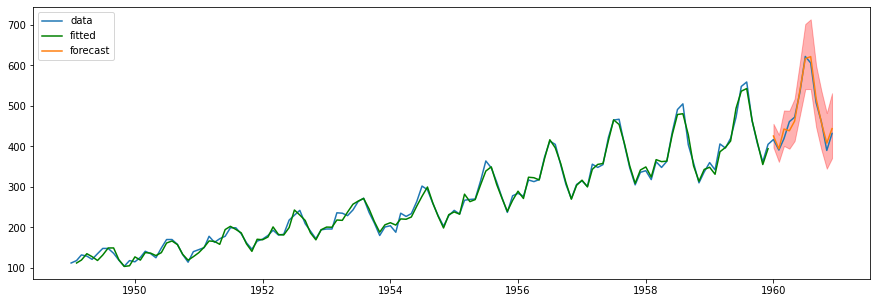

In [ ]:
# However, a high q helps slightly
arima_param = (12,1,12)
Ntest = 12  # 1 year
target_col = "Passengers"

ar = ARIMA(df.apply(np.log).iloc[:-Ntest][target_col], order=arima_param)  # apply log to df before fitting
ar_res = ar.fit()
plot_arima_results(ar_res, df, transform=np.exp)  # apply exp to fit results

### Choose d with Augmented Dickey-Fuller test

In [ ]:
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html
from statsmodels.tsa.stattools import adfuller

In [ ]:
adf_test = lambda df: adfuller(df.dropna())[1]

In [ ]:
# The smaller, the more stationary.
# The value suggests that we should differentiate once, ie. d=1.
print(f'df: {adf_test(df):.4f}')
print(f'log(df): {adf_test(df.apply(np.log)):.4f}')
print(f'df diff: {adf_test(df.diff()):.4f}')
print(f'log(df) diff: {adf_test(df.apply(np.log).diff()):.4f}')

df: 0.9919
log(df): 0.4224
df diff: 0.0542
log(df) diff: 0.0711


### Choose p with PACF

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

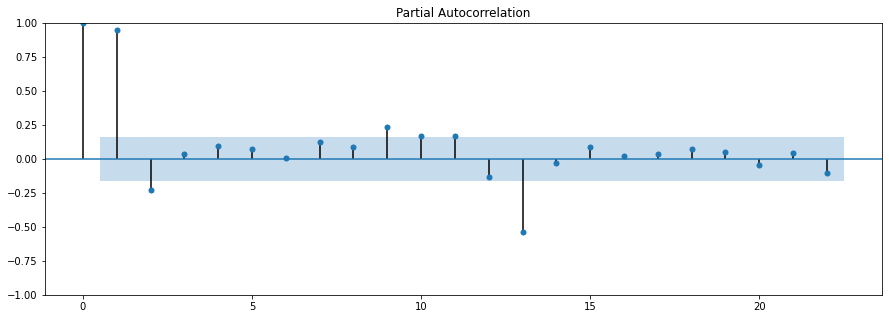

In [ ]:
# The plot suggests p=13 
fig, ax = plt.subplots(figsize=(15,5))
plot_pacf(df, ax, method='ywm');

### Choose q with ACF

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

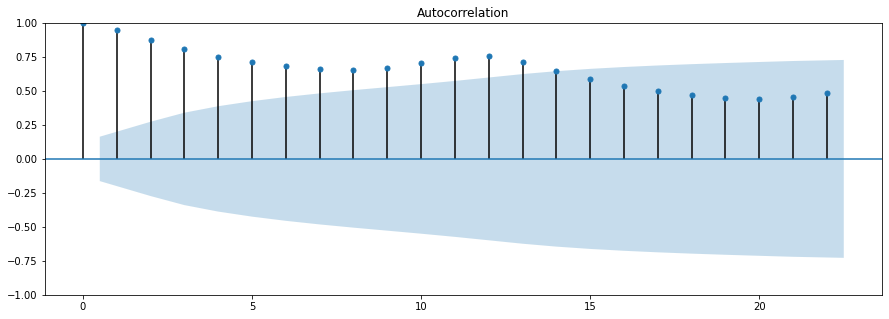

In [ ]:
# The plot suggests q in the range [5,12], although confidence interval is large
fig, ax = plt.subplots(figsize=(15,5))
plot_acf(df, ax);

### SARIMA

We have seen that the model improves significantly when including data from 12 periods before. We also know that the data is seasonal with periods 12. With plain ARIMA, the only way to include data from 12 periods before is to increase p and q, because there is no seasonality included in the model.

We should try SARIMA (P,D,Q,m=12), which includes a seasonal component. The differentiation part is done with respect to the m-th previous element, and not the immediate previous one.

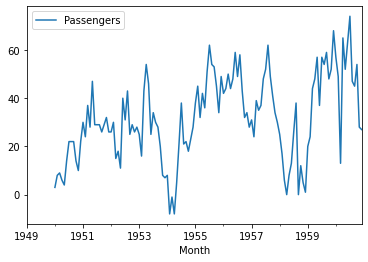

In [ ]:
# We can see that taking differences with respect to the previous 12-th element
# gives an almost stationary component, with an upward trend.
periods = 12  # 1 year
df.diff(periods).plot();

In [ ]:
# We check D with an ADF test on diff(12). It confirms D=1.
# We can also see that taking the log does not help.
print(f'df: {adf_test(df):.4f}')
print(f'df diff(12): {adf_test(df.diff(periods)):.4f}')
print(f'log(df) diff(12): {adf_test(df.apply(np.log).diff(periods)):.4f}')

df: 0.9919
df diff(12): 0.0116
log(df) diff(12): 0.0724


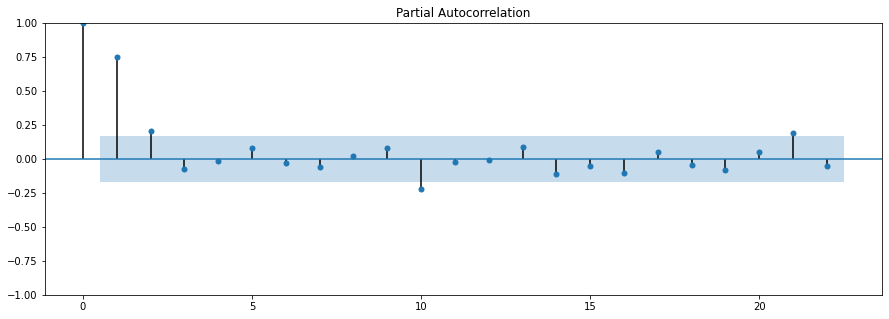

In [ ]:
# We choose P with a PACF plot on diff(12). It suggests P=1
fig, ax = plt.subplots(figsize=(15,5))
plot_pacf(df.diff(periods).dropna(), ax, method='ywm');

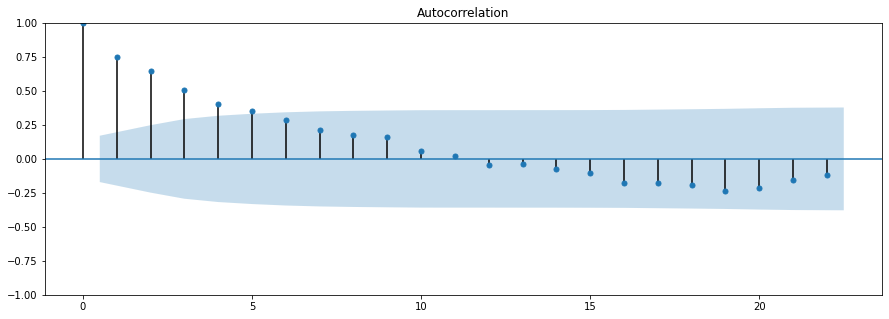

In [ ]:
# We choose Q with an ACF plot on diff(12). It suggests Q=3,4
fig, ax = plt.subplots(figsize=(15,5))
plot_acf(df.diff(periods).dropna(), ax);

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


RMSE = 17.0439


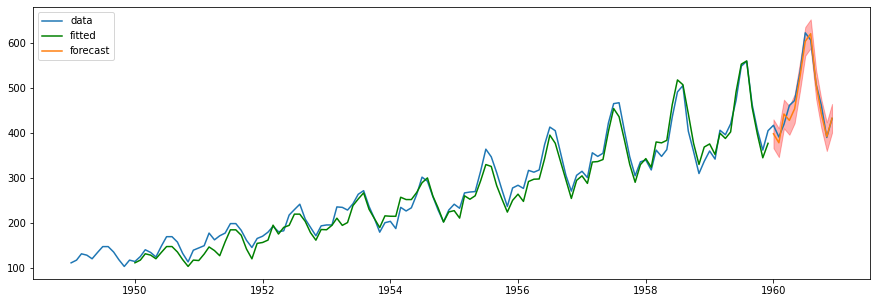

In [ ]:
# With the seasonal component we get a good model already with a low number of parameters.
arima_param = (0,0,0)
sarima_param = (1,1,3,periods)
Ntest = periods
target_col = "Passengers"

ar = ARIMA(df.iloc[:-Ntest][target_col], order=arima_param, seasonal_order=sarima_param)  # apply log to df before fitting
ar_res = ar.fit()
plot_arima_results(ar_res, df)  # apply exp to fit results

### Auto-ARIMA

We have seen that it makes sense to use a seasonal SARIMA model with m=12, but how do we choose all parameters? In particular: p, q, P, Q. With auto-ARIMA we can perform a (smart) grid search.

In [ ]:
periods = 12
Ntest = periods
target_col = "Passengers"

auto_ar = pm.auto_arima(df[:-Ntest][target_col], seasonal=True, m=periods,
                        trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=2.65 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1022.234, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=906.857, Time=0.59 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=963.555, Time=0.44 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1192.711, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=907.180, Time=0.18 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=908.543, Time=2.88 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.89 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=907.120, Time=0.42 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.42 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1021.611, Time=0.31 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=906.396, Time=0.59 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=906.075, Time=0.15 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=906.713, Time=0.43 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC

In [ ]:
auto_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  132
Model:             SARIMAX(3, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -447.843
Date:                            Mon, 19 Sep 2022   AIC                            905.686
Time:                                    07:19:57   BIC                            919.623
Sample:                                01-01-1949   HQIC                           911.346
                                     - 12-01-1959                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.5341      2.007      2.757      0.006       1.600       9.468
ar.L1          0.7049      0.095      7.393      0.000       0.518       0.892
ar.L2          0.2574      0.131      1.968      0.049       0.001       0.514
ar.L3         -0.1434      0.107     -1.338      0.181      -0.354       0.067
sigma2       101.0969     12.818      7.887      0.000      75.974     126.220
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.83
Prob(Q):                              0.96   Prob(JB):                         0.24
Heteroskedasticity (H):               1.41   Skew:                            -0.14
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

RMSE = 18.5365


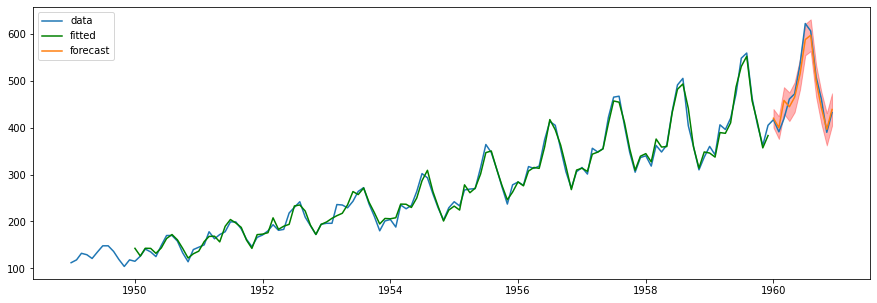

In [ ]:
plot_pmdarima_results(auto_ar, df);

RMSE = 18.5365


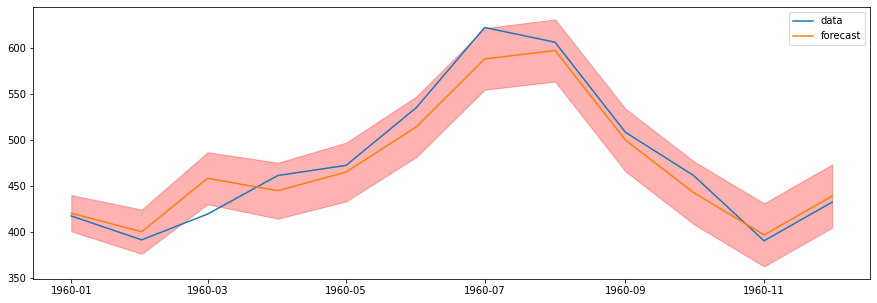

In [ ]:
plot_pmdarima_results(auto_ar, df, plot_train=False)

Let's try with a brute-force grid search (stepwise=False).

In [ ]:
periods = 12
Ntest = periods
target_col = "Passengers"

auto_ar = pm.auto_arima(df[:-Ntest][target_col], seasonal=True, m=periods,
                        stepwise=False, max_order=5,
                        trace=True, suppress_warnings=True)

 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1022.234, Time=0.07 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1022.029, Time=0.42 sec
 ARIMA(0,0,0)(0,1,2)[12] intercept   : AIC=1023.211, Time=1.48 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1021.611, Time=0.57 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.55 sec
 ARIMA(0,0,0)(1,1,2)[12] intercept   : AIC=1022.265, Time=3.29 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1022.869, Time=1.20 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=1024.889, Time=1.35 sec
 ARIMA(0,0,0)(2,1,2)[12] intercept   : AIC=inf, Time=3.10 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=965.311, Time=0.16 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=963.555, Time=0.40 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=965.277, Time=1.01 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=963.317, Time=0.60 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.38 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=967.282, Time=1.74 sec
 ARIMA(0,0,1)(2

In [ ]:
auto_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  132
Model:             SARIMAX(2, 0, 0)x(1, 1, [1, 2], 12)   Log Likelihood                -443.979
Date:                                 Mon, 19 Sep 2022   AIC                            901.959
Time:                                         07:34:05   BIC                            921.471
Sample:                                     01-01-1949   HQIC                           909.883
                                          - 12-01-1959                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1558      0.708      0.220      0.826      -1.231       1.542
ar.L1          0.6351      0.091      6.976      0.000       0.457       0.814
ar.L2          0.2358      0.090      2.632      0.008       0.060       0.411
ar.S.L12       0.9597      0.184      5.220      0.000       0.599       1.320
ma.S.L12      -1.2047      0.335     -3.601      0.000      -1.860      -0.549
ma.S.L24       0.3326      0.118      2.821      0.005       0.102       0.564
sigma2        88.2875     19.676      4.487      0.000      49.722     126.853
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.10
Prob(Q):                              0.96   Prob(JB):                         0.58
Heteroskedasticity (H):               1.56   Skew:                            -0.07
Prob(H) (two-sided):                  0.16   Kurtosis:                         3.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

RMSE = 15.7746


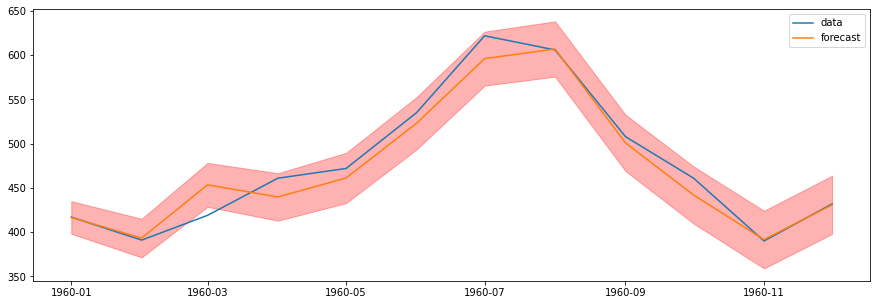

In [ ]:
plot_pmdarima_results(auto_ar, df, plot_train=False);